In [7]:
import sys
import os
from comet_ml import Experiment
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, average_precision_score
from sklearn.model_selection import RandomizedSearchCV

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))


from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot
from feature_engineering import preprocessing

## Random Forest Model

La structure de ce code est inspiré du lien suivant : https://medium.com/@ibrahimogunbiyi/how-to-deploy-comet-experiment-on-docker-d0324b56ce01

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/me-pic/milestone-2/1e6c86e4b86a4027bcb3e78e49ef49d3

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/1e6c86e4b86a4027bcb3e78e49ef49d3
COMET INFO:   Metrics:
COMET INFO:     train_average_precision    : 0.29182730827549563
COMET INFO:     train_best_score           : 0.9135833689232425
COMET INFO:     train_brier_score          : 0.07360328795399129
COMET INFO:     train_log_loss             : 0.2652373950875635
COMET INFO:     train_roc_auc              : 0.7484690196303267
COMET INFO:     validate_average_precision : 0.29182730827549563
COMET INFO:     validate_brier_score       : 0.07360328

AUC metric : 0.7484690196303267


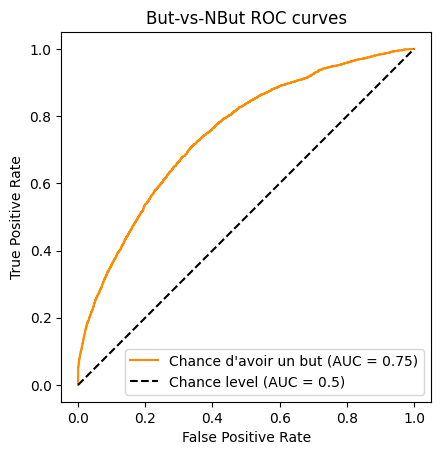

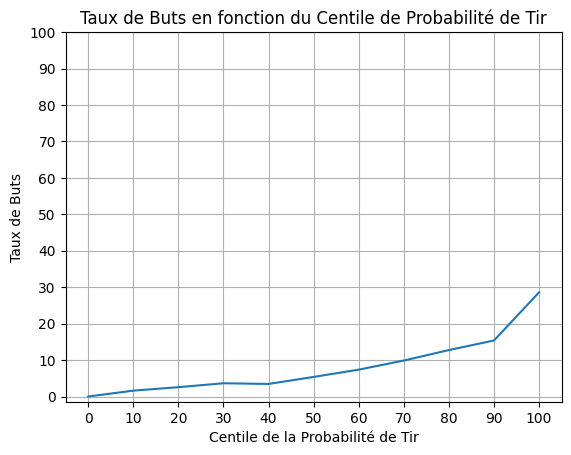

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

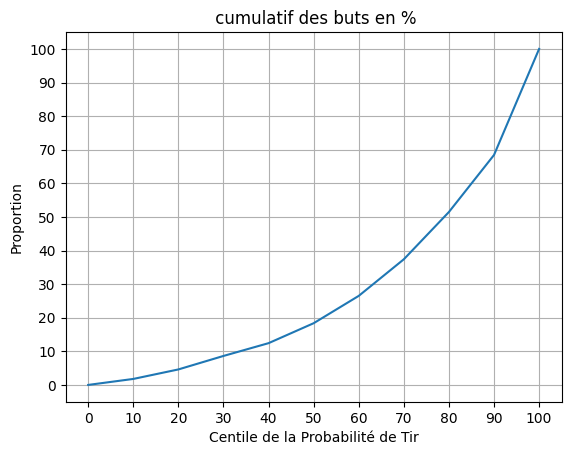

In [8]:


class CometExperiment:

    def __init__(self, path, artifact_name, api_key, project_name, workspace):
        self.path = path
        self.artifact_name = artifact_name
        self.api_key = api_key
        self.project_name = project_name
        self.workspace = workspace
        
    def read_data(self):
        df = pd.read_csv(self.path)
        X, y = preprocessing(df, 'goalFlag')
    
        result = train_test_split(X, y, test_size=0.2, random_state=42)
    
        return result
    
    def compute_metrics(self, y_test, y_probs):

        # Create dictionary called metrics to store all metrics
        metrics = {}
        metrics["roc_auc"] = roc_auc_score(y_test, y_probs[:, 1])
        metrics["average_precision"] = average_precision_score(y_test, y_probs[:, 1])
        metrics["log_loss"] = log_loss(y_test, y_probs)
        metrics["brier_score"] = brier_score_loss(y_test, y_probs[:, 1])

        return metrics
    
    def run_experiment(self, param_dist, model_name, n_iter=10, cv=3):

        #Instantiate the Experiment Object from comet
        experiment = Experiment(
            api_key=self.api_key,
            project_name= self.project_name,
            workspace= self.workspace)

        # Set the name of the experiment to be that of the model name passed
        experiment.set_name(model_name)
        experiment.add_tag(model_name)


        #Get the train and test data from read_data function
        X_train, X_test, y_train, y_test = self.read_data()
        
        model = RandomForestClassifier()
        randomized_search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=cv, scoring='accuracy', random_state=42)



        with experiment.train():
            
            randomized_search.fit(X_train, y_train)
            best_model = randomized_search.best_estimator_
            
            # Log les meilleurs hyperparamètres et la meilleure performance
            experiment.log_parameters(randomized_search.best_params_)
            experiment.log_metric("best_score", randomized_search.best_score_)

            y_probs = best_model.predict_proba(X_test)
            # Compute the mertrics
            metrics = self.compute_metrics(y_test, y_probs)

            #Log metrics to comet
            experiment.log_metrics(metrics)


        with experiment.validate():
            #Logs the text message to comet
            experiment.log_text("This is the Evaluation Metrics for the Validation Set")
            y_probs = best_model.predict_proba(X_test)

            #Compute metrics
            metrics = self.compute_metrics(y_test, y_probs)

            #Log metrics to comet
            experiment.log_metrics(metrics)
            
        
        experiment.log_model(name="Random Forest", file_or_folder='../notebooks/Random_Forest_model.ipynb')
        experiment.end()
        
        y_test = pd.Series(y_test)

        self.visualisation(best_model, y_probs, y_test, X_test)
                   
    def visualisation(self, best_model, y_probs, y_test, X_test):
        ROC_plot(y_test, y_probs[:, 1])
        Centiles_plot(y_test, y_probs[:, 1])
        cumulative_centiles_plot(y_test, y_probs[:, 1])

        CalibrationDisplay.from_estimator(best_model, X_test, y_test, n_bins=50)   
    
if __name__ == "__main__":
    API_KEY = os.environ.get('COMET_API_KEY')
    project_name = "milestone-2"
    workspace = "me-pic"
    
    path = "../data/derivatives/train_data.csv"
    artifact_name = "train_data"

   #Initialize the Object
    project = CometExperiment(path, artifact_name, API_KEY, project_name, workspace)
    
    # Défininition de l'espace des hyperparamètres
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    #Pass in the model and it's name
    project.run_experiment(param_grid, "Random Forest")